In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np

from src import config
import src.optimization_utils as ou


### 1. Data Cleaning & Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# Load cleaned data from config path
df = pd.read_csv(config.DATA_PROCESSED)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {len(df)} patients, {df.shape[1]} columns")
print(f"Data path: {config.DATA_PROCESSED}")


Loaded 271 patients, 109 columns
Data path: /Users/jennkim/Documents/capstone/code/Data-Science-Capstone/data/processed/cleaned_for_modeling.csv


In [3]:
#change data type to numeric for calculation
df[["gap_score_preop", "gap_score_postop"]]\
    = df[["gap_score_preop", "gap_score_postop"]]\
        .apply(pd.to_numeric, errors="coerce").astype("Int64")
df[["ODI_preop", "ODI_12mo"]]\
    = df[["ODI_preop", "ODI_12mo"]]\
        .apply(pd.to_numeric, errors="coerce").astype(float)

### 1.1 Define input and response variables

In [ ]:
#patient preop fixed parameters
PATIENT_FIXED_COLS = config.PATIENT_FIXED_COLS
FEATURES = config.DELTA_MODEL_FEATURES.copy()

print("== FEATURES ==")
for i in FEATURES:
    print(i)

FEATURES.remove("gap_score_preop")
FEATURES.remove("gap_category")

#from Hari's code
'''NUMERIC_FEATURES = df[FEATURES].select_dtypes(
    exclude=["object", "string", "category"]
).columns.tolist()

CATEGORICAL_FEATURES = df[FEATURES].select_dtypes(
    include=["object", "string", "category"]
).columns.tolist()'''

print("\n == Numerical Features (includes binary) ==")
for i in NUMERIC_FEATURES:
    print(i)

print("\n == Categorical Features ==")
for i in CATEGORICAL_FEATURES:
    print(i)


== FEATURES ==
age
sex
bmi
C7CSVL_preop
SVA_preop
T4PA_preop
L1PA_preop
LL_preop
L4S1_preop
PT_preop
PI_preop
SS_preop
cobb_main_curve_preop
FC_preop
tscore_femneck_preop
HU_UIV_preop
HU_UIVplus1_preop
HU_UIVplus2_preop
gap_category
gap_score_preop
global_tilt_preop
CCI
ASA_CLASS
ODI_preop
UIV_implant
num_levels_cat
num_interbody_fusion_levels
ALIF
XLIF
TLIF
num_rods
num_pelvic_screws
osteotomy

 == Numerical Features (includes binary) ==
age
bmi
C7CSVL_preop
SVA_preop
T4PA_preop
L1PA_preop
LL_preop
L4S1_preop
PT_preop
PI_preop
SS_preop
cobb_main_curve_preop
FC_preop
tscore_femneck_preop
HU_UIV_preop
HU_UIVplus1_preop
HU_UIVplus2_preop
global_tilt_preop
CCI
ODI_preop
num_interbody_fusion_levels
ALIF
XLIF
TLIF
num_rods
num_pelvic_screws
osteotomy

 == Categorical Features ==
sex
ASA_CLASS
UIV_implant
num_levels_cat


In [5]:
if "delta_L4S1" not in df.columns:
    df["delta_L4S1"] = df["L4_S1_postop"] - df["L4S1_preop"]

if "delta_LL" not in df.columns:
    df["delta_LL"] = df["LL_postop"] - df["LL_preop"]

if "delta_T4PA" not in df.columns:
    df["delta_T4PA"] = df["T4PA_postop"] - df["T4PA_preop"]

if "delta_L1PA" not in df.columns:
    df["delta_L1PA"] = df["L1PA_postop"] - df["L1PA_preop"]

if "delta_ODI" not in df.columns:
    df["delta_ODI"] = df["ODI_12mo"] - df["ODI_preop"] 

### 2. Build Models

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, PredictionErrorDisplay, make_scorer

from xgboost import XGBRegressor

### 2.1 Set up for model building and hyperparameter tuning

In [ ]:
#same as Hari's
'''numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )'''

ridge_numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
    )
#same as Hari's
'''categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),  
           ("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ]
    )'''

# Transform heterogeneous data types; same as Hari's
'''preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
        ]
    )'''
ridge_preprocessor = ColumnTransformer(
    transformers=[
        ("num", ridge_numeric_transformer,  NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
        ]
    )



In [ ]:
def train_rf_model(target_col, model_name):
    "Builds and fits a Random Forest model using a pipeline"

    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=300, 
                                            random_state=42,
                                            max_depth=8,
                                            min_samples_leaf=5,
                                            oob_score=True)

    pipe = Pipeline([
        ("preprocessor", clone(preprocessor)), 
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    mae = mean_absolute_error(y_test, preds)
    oob = pipe.named_steps["regressor"].oob_score_
    
    print(f"\n{model_name}")

    print(f"R² score: {round(r2,3)}")
    print(f"RMSE: {round(rmse,3)}")
    print(f"MAE: {round(mae, 3)}")
    print(f"OOB score: {round(oob,3)}")

    return pipe, X_test, y_test, preds

def train_ridge_model(target_col, model_name,alpha=1):
    "Builds and fits a Ridge Regression model within a pipeline"

    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=alpha))
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    r2 = r2_score(y_test,preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    print(f"\n{model_name}")

    print(f"R² score: {round(r2,3)}")
    print(f"RMSE: {round(rmse,3)}")
    print(f"MAE: {round(mae, 3)}")

    return pipe, X_test, y_test,preds    


'def train_rf_model(X_train, X_test, y_train, y_test):\n    "Builds and fits a Random Forest model using a pipeline"\n\n    pipeline = Pipeline([\n        ("preprocessor", clone(preprocessor)), \n        ("regressor", RandomForestRegressor(n_estimators=300, \n                                            random_state=42,\n                                            max_depth=8,\n                                            min_samples_leaf=5,\n                                            oob_score=True))\n    ])\n\n    pipeline.fit(X_train, y_train)\n\n    y_pred = pipeline.predict(X_test)\n\n    r2 = r2_score(y_test, y_pred)\n    rmse = np.sqrt(mean_squared_error(y_test, y_pred))\n    mae = mean_absolute_error(y_test, y_pred)\n    oob = pipeline.named_steps["regressor"].oob_score_\n\n    print("-- Random Forest Model --")\n\n    print(f"R² score: {round(r2,3)}")\n    print(f"RMSE: {round(rmse,3)}")\n    print(f"MAE: {round(mae, 3)}")\n    print(f"OOB score: {round(oob,3)}")\n\n    return 

### 3. Model Evaluation 
#### 3.1 Model 1: L4S1

In [9]:
L4S1_model, X_test_L4S1, y_test_L4S1, y_pred_L4S1 = train_ridge_model("delta_L4S1", "ΔL4S1 Model")


ΔL4S1 Model
R² score: 0.591
RMSE: 9.68
MAE: 7.33


#### Visualization

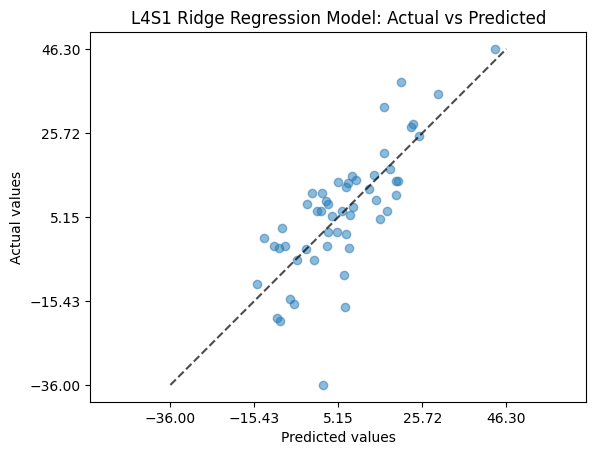

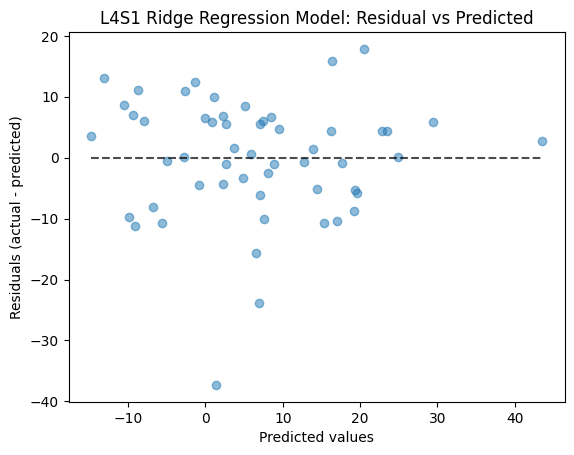

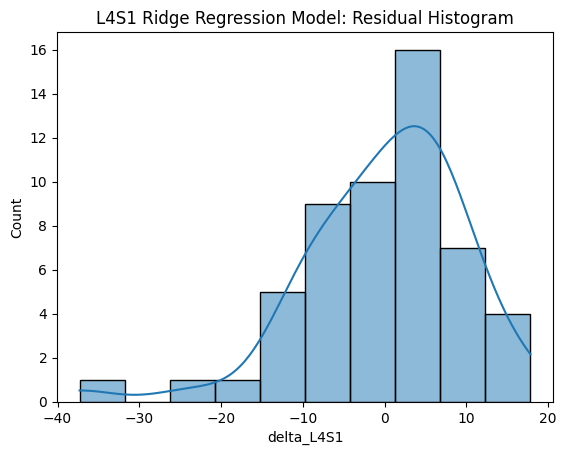

In [11]:
#actual vs predicted plot
fig, ax = plt.subplots()
ax.set_title("L4S1 Ridge Regression Model: Actual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_L4S1, 
    y_pred=y_pred_L4S1, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()
#residual vs predicted plot
fig, ax = plt.subplots()

ax.set_title("L4S1 Ridge Regression Model: Residual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_L4S1, 
    y_pred=y_pred_L4S1, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()

#residual histogram

fig, ax = plt.subplots()
ax.set_title("L4S1 Ridge Regression Model: Residual Histogram")

L4S1_residuals = y_test_L4S1 - y_pred_L4S1
sns.histplot(x=L4S1_residuals, kde=True, ax=ax)

plt.show()


#### Feature Importance

In [12]:
import shap
explainer = shap.Explainer(L4S1_model.named_steps["regressor"],
                           feature_names=L4S1_model.named_steps["preprocessor"].get_feature_names_out())
shap_values = explainer(X_test_L4S1)
shap.summary_plot(shap_values, X_test_L4S1, plot_type="bar")


ModuleNotFoundError: No module named 'shap'

In [ ]:
shap.plots.beeswarm(shap_values)

#### 3.2 Model 2: LL

In [23]:
LL_model, X_test_LL, y_test_LL, y_pred_LL= train_rf_model("delta_LL", "ΔLL Model")


ΔLL Model
R² score: 0.521
RMSE: 9.458
MAE: 7.612
OOB score: 0.574


#### Visualization of model performance

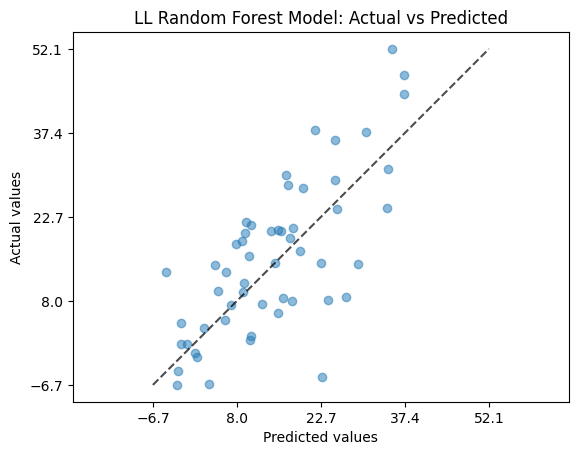

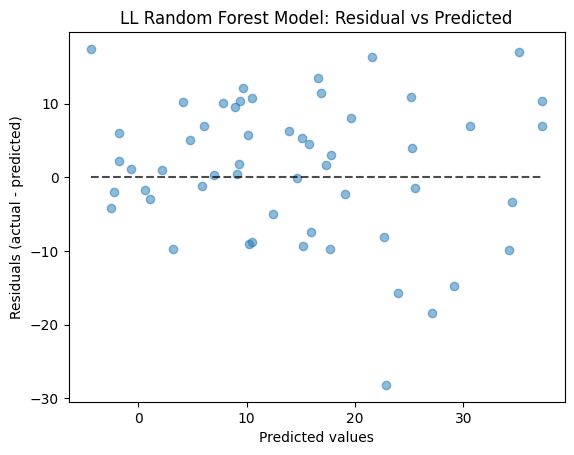

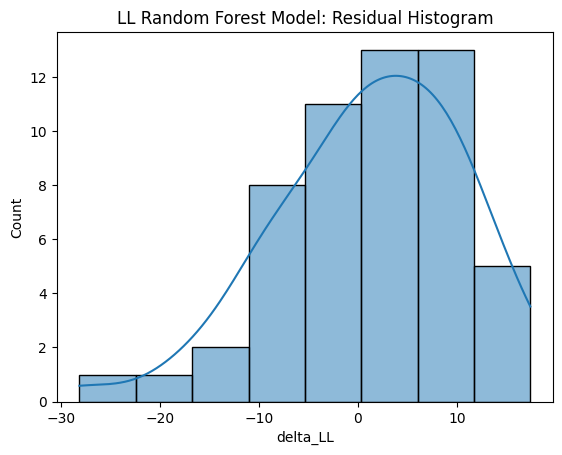

In [ ]:
#actual vs predicted plot
fig, ax = plt.subplots()
ax.set_title("LL Random Forest Model: Actual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_LL, 
    y_pred=y_pred_LL, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()
#residual vs predicted plot
fig, ax = plt.subplots()

ax.set_title("LL Random Forest Model: Residual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_LL, 
    y_pred=y_pred_LL, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()

#residual histogram

fig, ax = plt.subplots()
ax.set_title("LL Random Forest Model: Residual Histogram")

LL_residuals = y_test_LL - y_pred_LL
sns.histplot(x=LL_residuals, kde=True, ax=ax)

plt.show()

#### Feature Importance

In [ ]:
explainer = shap.Explainer(LL_model.named_steps["regressor"],
                           feature_names=LL_model.named_steps["preprocessor"].get_feature_names_out())
shap_values = explainer(X_test_LL)
shap.summary_plot(shap_values, X_test_LL, plot_type="bar")


In [ ]:
shap.plots.beeswarm(shap_values)

### 3.3 Model 3:T4PA Change

In [ ]:
T4PA_model, X_test_T4PA, y_test_T4PA, y_pred_T4PA = train_ridge_model("delta_T4PA", "ΔT4PA Model")


ΔT4PA Model
R² score: 0.544
RMSE: 6.822
MAE: 5.331


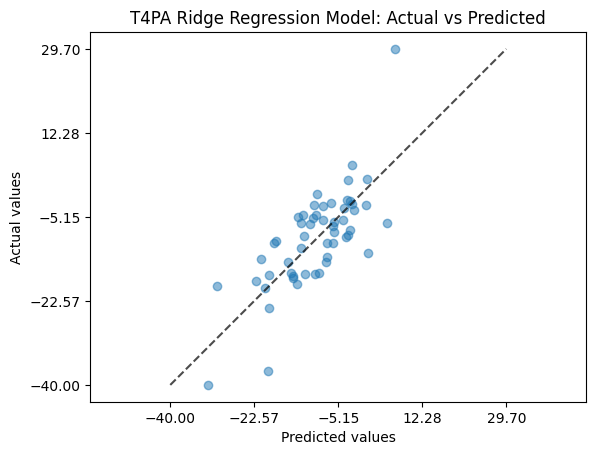

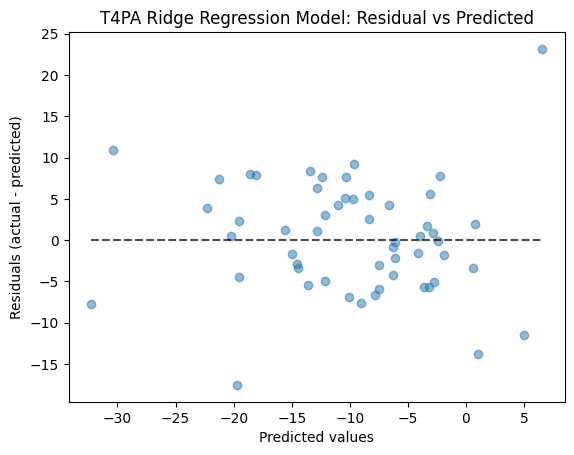

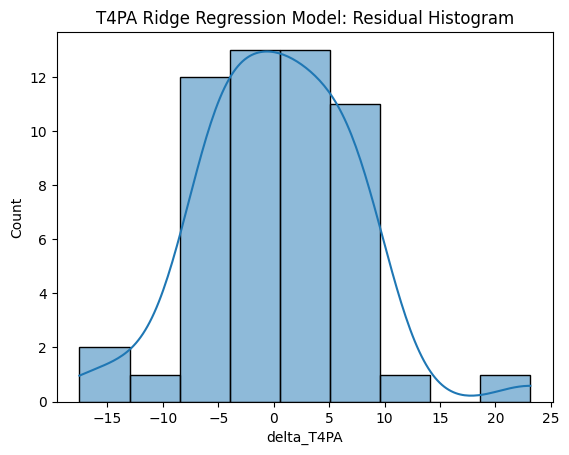

In [ ]:
#actual vs predicted plot
fig, ax = plt.subplots()
ax.set_title("T4PA Ridge Regression Model: Actual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_T4PA, 
    y_pred=y_pred_T4PA, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()
#residual vs predicted plot
fig, ax = plt.subplots()

ax.set_title("T4PA Ridge Regression Model: Residual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_T4PA, 
    y_pred=y_pred_T4PA, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()

#residual histogram
fig, ax = plt.subplots()
ax.set_title("T4PA Ridge Regression Model: Residual Histogram")

T4PA_residuals = y_test_T4PA - y_pred_T4PA
sns.histplot(x=T4PA_residuals, kde=True, ax=ax)

plt.show()


#### Feature Importance

In [ ]:
explainer = shap.Explainer(T4PA_model.named_steps["regressor"],
                           feature_names=T4PA_model.named_steps["preprocessor"].get_feature_names_out())
shap_values = explainer(X_test_T4PA)
shap.summary_plot(shap_values, X_test_T4PA, plot_type="bar")

In [ ]:
shap.plots.beeswarm(shap_values)

### 3.4 Model 4:L1PA Change

In [12]:
df["delta_L1PA"] = df["L1PA_postop"] - df["L1PA_preop"]

df_L1PA = df.dropna(subset=["delta_L1PA"])
    
X = df_L1PA[FEATURES]
y = df_L1PA["delta_L1PA"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
L1PA_model, X_test_L1PA, y_test_L1PA, y_pred_L1PA = train_ridge_model("delta_L1PA", "ΔL1PA Model")


ΔL1PA Model
R² score: 0.502
RMSE: 4.646
MAE: 3.422


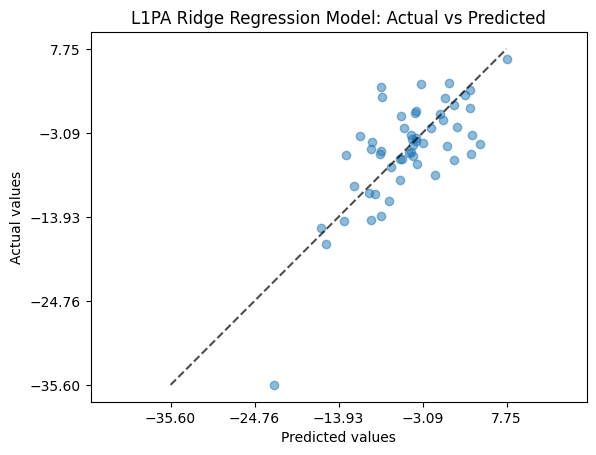

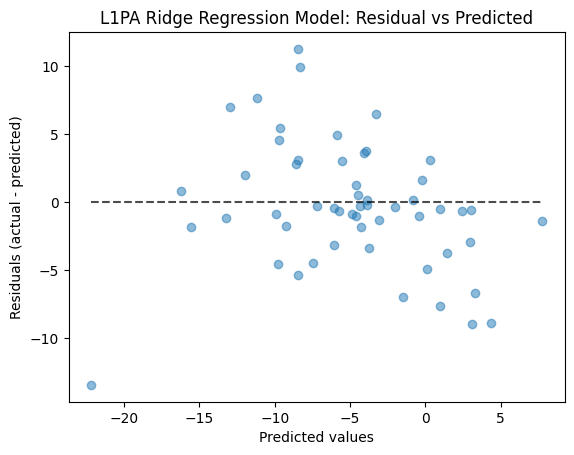

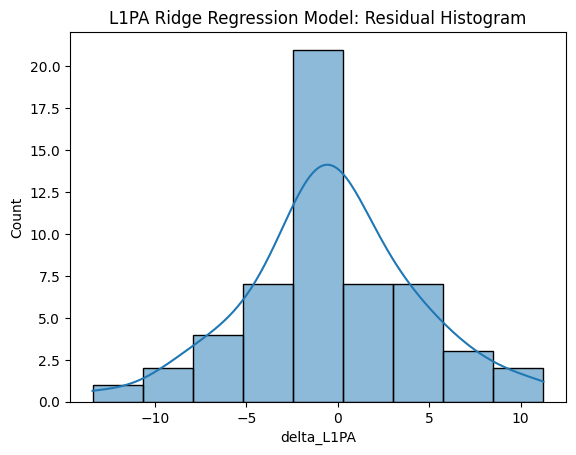

In [16]:
#actual vs predicted plot
fig, ax = plt.subplots()
ax.set_title("L1PA Ridge Regression Model: Actual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_L1PA, 
    y_pred=y_pred_L1PA, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()
#residual vs predicted plot
fig, ax = plt.subplots()

ax.set_title("L1PA Ridge Regression Model: Residual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_L1PA, 
    y_pred=y_pred_L1PA, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()

#residual histogram
fig, ax = plt.subplots()
ax.set_title("L1PA Ridge Regression Model: Residual Histogram")

L1PA_residuals = y_test_L1PA - y_pred_L1PA
sns.histplot(x=L1PA_residuals, kde=True, ax=ax)

plt.show()


#### Feature Importance

In [ ]:
explainer = shap.Explainer(L1PA_model.named_steps["regressor"],
                           feature_names=L1PA_model.named_steps["preprocessor"].get_feature_names_out())
shap_values = explainer(X_test_L1PA)
shap.summary_plot(shap_values, X_test_L1PA, plot_type="bar")

In [ ]:
shap.plots.beeswarm(shap_values)

#### 3.5 MODEL 5: ODI After 12 months

In [14]:
ODI_model, X_test_ODi,y_test_ODI, y_pred_ODI = train_ridge_model("delta_ODI", "ΔODI Model")



ΔODI Model
R² score: 0.549
RMSE: 17.134
MAE: 14.739


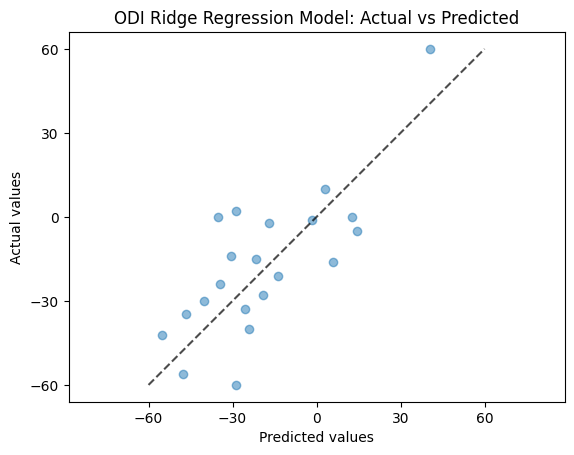

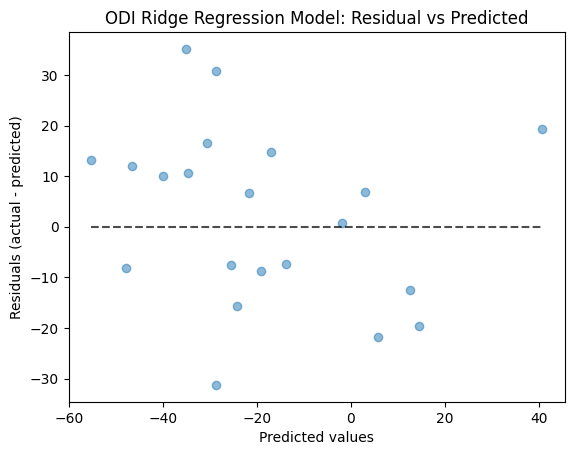

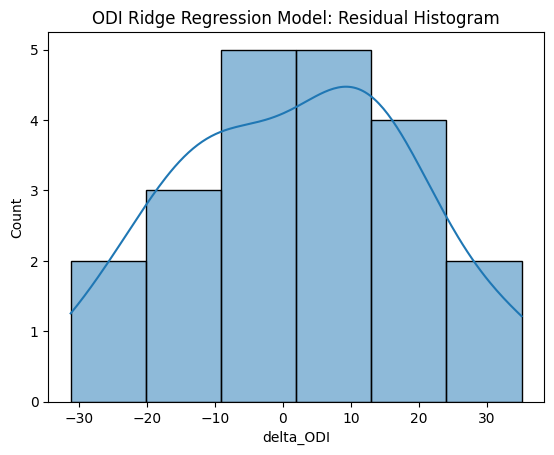

In [19]:
#actual vs predicted plot
fig, ax = plt.subplots()
ax.set_title("ODI Ridge Regression Model: Actual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_ODI, 
    y_pred=y_pred_ODI, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()
#residual vs predicted plot
fig, ax = plt.subplots()

ax.set_title("ODI Ridge Regression Model: Residual vs Predicted")

PredictionErrorDisplay.from_predictions(
    y_true=y_test_ODI, 
    y_pred=y_pred_ODI, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)

plt.show()

#residual histogram
fig, ax = plt.subplots()
ax.set_title("ODI Ridge Regression Model: Residual Histogram")

ODI_residuals = y_test_ODI - y_pred_ODI
sns.histplot(x=ODI_residuals, kde=True, ax=ax)

plt.show()


### 4. Export Model

In [15]:
def final_rf_model(target_col):
    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    model = RandomForestRegressor(n_estimators=300, 
                                            random_state=42,
                                            max_depth=8,
                                            min_samples_leaf=5,
                                            oob_score=True)

    pipe = Pipeline([
        ("preprocessor", clone(preprocessor)), 
        ("regressor", model)
    ])

    pipe.fit(X, y)

    return pipe

def final_ridge_model(target_col, alpha=1):
    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    pipe = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=alpha))
    ])

    pipe.fit(X, y)

    return pipe

In [17]:
#build final model for deployment - L4S1 ridge regression 
L4S1_pipe = final_ridge_model("delta_L4S1")
L4S1_pipe


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [19]:
#build final model for deployment - LL random forest

LL_pipe = final_rf_model("delta_LL")
LL_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [20]:
#build final model for deployment - T4PA ridge regression
T4PA_pipe = final_ridge_model("delta_T4PA")
T4PA_pipe


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [21]:
#build final model for deployment - L1PA ridge regression
L1PA_pipe = final_ridge_model("delta_L1PA")
L1PA_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [22]:
#build final model for deployment - ODI ridge regression
ODI_pipe = final_ridge_model("delta_L1PA")
ODI_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [ ]:
import joblib, sklearn
from src import config

# L4S1 model
L4S1_dir = config.ARTIFACTS_DIR / "L4S1"
L4S1_dir.mkdir(parents=True, exist_ok=True)

bundle_L4S1 = {
    "pipe": L4S1_pipe,
    "features": FEATURES,
    "target": "delta_L4S1",
    "sklearn_version": sklearn.__version__,
    "model_name": "RidgeRegressor_delta_L4S1"
}
out_path = L4S1_dir / "delta_L4S1_model.joblib"
joblib.dump(bundle_L4S1, out_path)
print("Saved:", out_path)

# LL model
LL_dir = config.ARTIFACTS_DIR / "LL"
LL_dir.mkdir(parents=True, exist_ok=True)

bundle_LL = {
    "pipe": LL_pipe,
    "features": FEATURES,
    "target": "delta_LL",
    "sklearn_version": sklearn.__version__,
    "model_name": "RandomForest_delta_LL",
}

out_path = LL_dir / "delta_LL_model.joblib"
joblib.dump(bundle_LL, out_path)
print("Saved:", out_path)

# T4PA model
T4PA_dir = config.ARTIFACTS_DIR / "T4PA"
T4PA_dir.mkdir(parents=True, exist_ok=True)

bundle_T4PA = {
    "pipe": T4PA_pipe,
    "features": FEATURES,
    "target": "delta_T4PA",
    "sklearn_version": sklearn.__version__,
    "model_name": "RidgeRegressor_delta_T4PA",
}

out_path = T4PA_dir / "delta_T4PA_model.joblib"
joblib.dump(bundle_T4PA, out_path)
print("Saved:", out_path)

# L1PA model
L1PA_dir = config.ARTIFACTS_DIR / "L1PA"
L1PA_dir.mkdir(parents=True, exist_ok=True)

bundle_L1PA = {
    "pipe": L1PA_pipe,
    "features": FEATURES,
    "target": "delta_L1PA",
    "sklearn_version": sklearn.__version__,
    "model_name": "RidgeRegressor_delta_L1PA",
}

out_path = L1PA_dir / "delta_L1PA_model.joblib"
joblib.dump(bundle_L1PA, out_path)
print("Saved:", out_path)

# ODI model
ODI_dir = config.ARTIFACTS_DIR / "ODI"
ODI_dir.mkdir(parents=True, exist_ok=True)

bundle_ODI = {
    "pipe": ODI_pipe,
    "features": FEATURES,
    "target": "delta_ODI",
    "sklearn_version": sklearn.__version__,
    "model_name": "RidgeRegressor_delta_ODI",
}

out_path = ODI_dir / "delta_ODI_model.joblib"
joblib.dump(bundle_ODI, out_path)
print("Saved:", out_path)